In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# 加载 GLM 模型和分词器
tokenizer = AutoTokenizer.from_pretrained(r'E:\serverfiles\chatglm2-6b-int4',trust_remote_code=True)  # 以 GLM 中文模型为例
model = AutoModel.from_pretrained(r'E:\serverfiles\chatglm2-6b-int4',trust_remote_code=True).cuda()

# 药物名称列表
drug_names = ["阿司匹林", "布洛芬", "对乙酰氨基酚", "华法林", "芬太尼"]

# 计算药物名称的嵌入表示
def get_glm_embedding(text):
    # 分词并转换为模型输入
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to('cuda')
    
    # 获取模型输出
    outputs = model(**inputs)
    
    # 提取嵌入表示
    if hasattr(outputs, 'last_hidden_state'):
        # 如果模型输出包含 last_hidden_state
        embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    else:
        # 如果模型输出不包含 last_hidden_state，尝试其他字段
        embeddings = outputs[0][:, 0, :].detach().cpu().numpy()  # 假设 outputs 是一个元组
    
    return embeddings

drug_embeddings = np.array([get_glm_embedding(name) for name in drug_names])
drug_embeddings = drug_embeddings.reshape(len(drug_names), -1)  # 调整形状

# 计算语义相似度矩阵
similarity_matrix = np.dot(drug_embeddings, drug_embeddings.T)
norms = np.linalg.norm(drug_embeddings, axis=1)
similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化

print(similarity_matrix)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\David/.cache\huggingface\modules\transformers_modules\chatglm2-6b-int4\modeling_chatglm.py:224: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(query_layer, key_layer, value_layer,


[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


D:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\David\AppData\Local\Temp\ipykernel_29408\1512782922.py:36: RuntimeWarning: invalid value encountered in divide
  similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化


Some weights of the model checkpoint at E:\models\bert-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[0.9999999  0.7113487  0.84630907 0.8052413  0.81363666]
 [0.7113487  0.9999995  0.7122158  0.7643002  0.80385935]
 [0.84630907 0.7122158  0.99999994 0.77142483 0.8146155 ]
 [0.8052413  0.7643002  0.77142483 0.99999994 0.85350007]
 [0.81363666 0.80385935 0.8146155  0.85350007 1.0000002 ]]


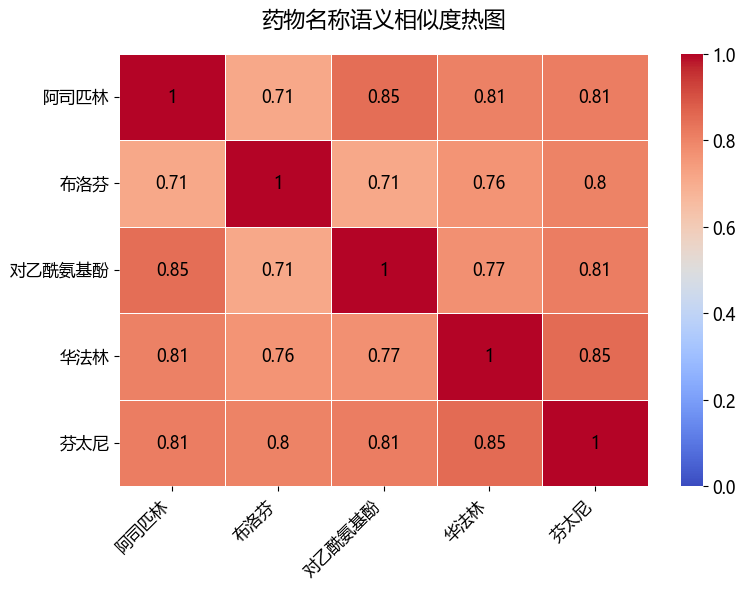

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载 BERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained(r'E:\models\bert-chinese')  # 以 GLM 中文模型为例
model = AutoModel.from_pretrained(r'E:\models\bert-chinese')

# 药物名称列表
drug_names = ["阿司匹林", "布洛芬", "对乙酰氨基酚", "华法林", "芬太尼"]

# 计算药物名称的嵌入表示
def get_glm_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    # 使用 [CLS] 标记的嵌入作为句子表示
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

drug_embeddings = np.array([get_glm_embedding(name) for name in drug_names])
drug_embeddings = drug_embeddings.reshape(len(drug_names), -1)  # 调整形状

# 计算语义相似度矩阵
similarity_matrix = np.dot(drug_embeddings, drug_embeddings.T)
norms = np.linalg.norm(drug_embeddings, axis=1)
similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化

print(similarity_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=drug_names, columns=drug_names)

# 创建热图
plt.figure(figsize=(8, 6))

# 使用更美观的颜色映射（如 'coolwarm' 或 'magma'）
ax = sns.heatmap(
    similarity_df,
    annot=True,
    cmap='coolwarm',  # 颜色映射
    vmin=0,
    vmax=1,
    annot_kws={"size": 12, "color": "black"},  # 注释字体大小和颜色
    linewidths=0.5,  # 单元格之间的线宽
    linecolor='white'  # 单元格之间的线颜色
)

# 设置标题
plt.title("药物名称语义相似度热图", fontsize=16, pad=20)

# 设置坐标轴标签字体大小
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, rotation=0)

# 添加颜色条标签
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# 显示热图
plt.tight_layout()
plt.show()

Some weights of the model checkpoint at E:\models\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


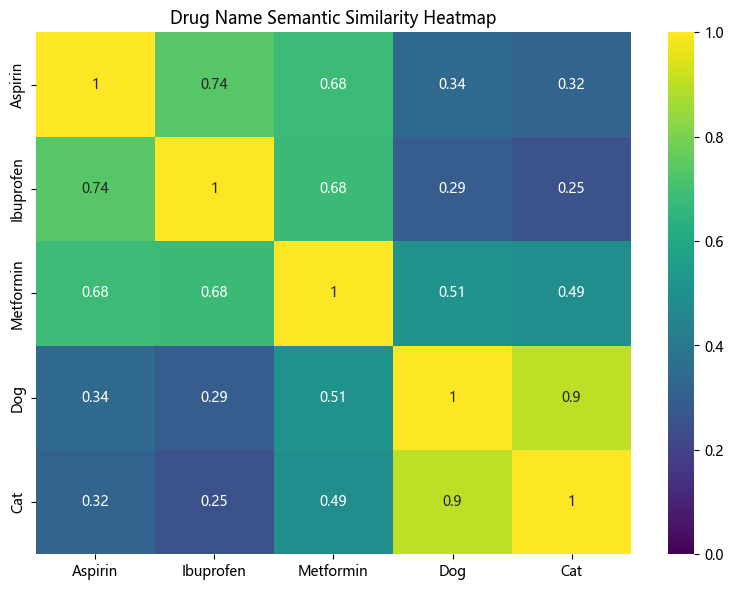

In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# 加载 BERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained(r'E:\models\bert-base-uncased')
model = AutoModel.from_pretrained(r'E:\models\bert-base-uncased')

# 药物名称列表
drug_names = ["Aspirin", "Ibuprofen",'Metformin','Dog','Cat']

# 计算药物名称的嵌入表示
def get_bert_embedding(text):
    # 分词并转换为模型输入
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # 获取模型输出
    outputs = model(**inputs)
    
    # 提取所有 token 的嵌入表示
    token_embeddings = outputs.last_hidden_state  # 形状: (batch_size, sequence_length, hidden_size)
    
    # 均值池化：对所有 token 的嵌入取平均值
    mean_embedding = torch.mean(token_embeddings, dim=1)  # 形状: (batch_size, hidden_size)
    
    # 转换为 NumPy 数组并返回
    return mean_embedding.detach().numpy()

drug_embeddings = np.array([get_bert_embedding(name) for name in drug_names])
drug_embeddings = drug_embeddings.reshape(len(drug_names), -1)  # 调整形状

# 计算语义相似度矩阵
similarity_matrix = np.dot(drug_embeddings, drug_embeddings.T)
norms = np.linalg.norm(drug_embeddings, axis=1)
similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化

# 将相似度矩阵转换为 DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=drug_names, columns=drug_names)

# 创建热图
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='viridis', vmin=0, vmax=1)

# 添加标题
plt.title("Drug Name Semantic Similarity Heatmap")

# 显示热图
plt.tight_layout()
plt.show()

In [8]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# 加载 BERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained(r'E:\models\bert-base-uncased')
model = AutoModel.from_pretrained(r'E:\models\bert-base-uncased')

# 药物名称列表
drug_names = ["Aspirin", "Ibuprofen",'Metformin','Dog','Cat']

# 计算药物名称的嵌入表示
def get_bert_embedding(text):
    # 分词并转换为模型输入
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # 获取模型输出
    outputs = model(**inputs)
    
    # 提取所有 token 的嵌入表示
    token_embeddings = outputs.last_hidden_state  # 形状: (batch_size, sequence_length, hidden_size)
    
    # 均值池化：对所有 token 的嵌入取平均值
    mean_embedding = torch.mean(token_embeddings, dim=1)  # 形状: (batch_size, hidden_size)
    
    # 转换为 NumPy 数组并返回
    return mean_embedding.detach().numpy()

drug_embeddings = np.array([get_bert_embedding(name) for name in drug_names])
drug_embeddings = drug_embeddings.reshape(len(drug_names), -1)  # 调整形状

# 计算语义相似度矩阵
similarity_matrix = np.dot(drug_embeddings, drug_embeddings.T)
norms = np.linalg.norm(drug_embeddings, axis=1)
similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化

# 将相似度矩阵转换为 DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=drug_names, columns=drug_names)

Some weights of the model checkpoint at E:\models\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


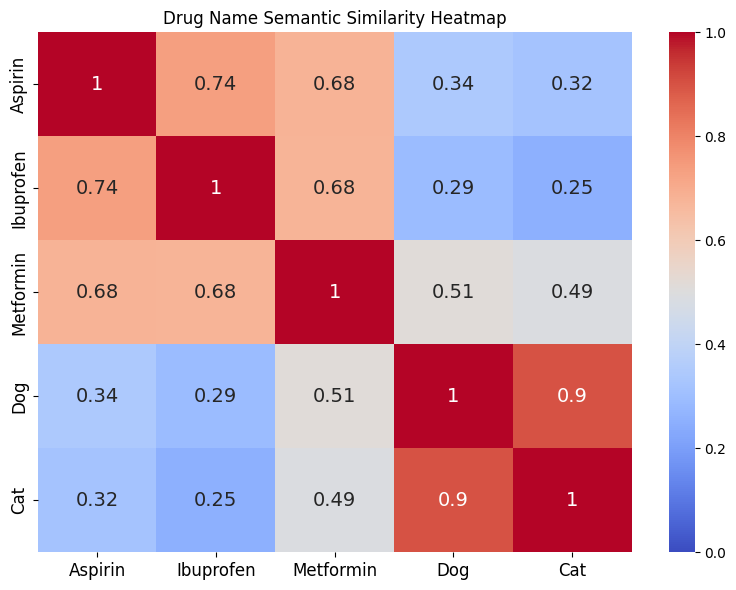

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用黑体
#plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
#zh_name = ['阿司匹林','布洛芬','二甲双胍','狗','猫']
zh_name = ["Aspirin", "Ibuprofen",'Metformin','Dog','Cat']
# 假设 similarity_matrix 和 drug_names 已经定义
similarity_df = pd.DataFrame(similarity_matrix, index=zh_name, columns=zh_name)

# 创建热图
plt.figure(figsize=(8, 6))
sns.heatmap(
    similarity_df,
    annot=True,  # 显示注释
    annot_kws={"size": 14},  # 调整注释文字大小
    #cmap='viridis',
    cmap='coolwarm',
    vmin=0,
    vmax=1,
    xticklabels=True,  # 显示 x 轴标签
    yticklabels=True   # 显示 y 轴标签
)

# 调整坐标轴标签文字大小
plt.xticks(fontsize=12)  # 调整 x 轴标签文字大小
plt.yticks(fontsize=12)  # 调整 y 轴标签文字大小

# 添加标题并调整标题文字大小
#plt.title("语义相似性热图", fontsize=16)
plt.title("Drug Name Semantic Similarity Heatmap")
# 显示热图
plt.tight_layout()
plt.show()

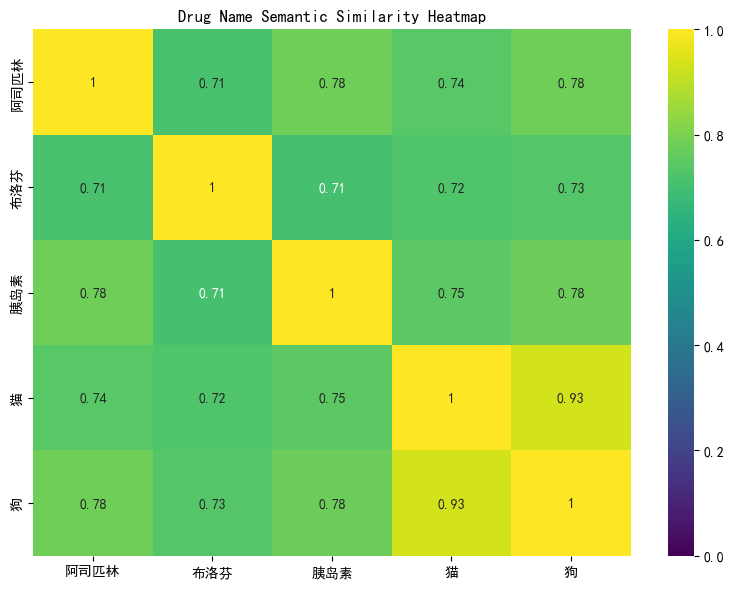

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 将相似度矩阵转换为 DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=drug_names, columns=drug_names)

# 创建热图
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='viridis', vmin=0, vmax=1)

# 添加标题
plt.title("Drug Name Semantic Similarity Heatmap")

# 显示热图
plt.tight_layout()
plt.show()

Some weights of the model checkpoint at E:\models\bert-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[0.9999999  0.7113487  0.77973837 0.7404269  0.7795221 ]
 [0.7113487  0.9999995  0.7053161  0.7229276  0.7312566 ]
 [0.77973837 0.7053161  0.99999994 0.7492345  0.775646  ]
 [0.7404269  0.7229276  0.7492345  0.99999976 0.9299701 ]
 [0.7795221  0.7312566  0.775646   0.9299701  0.9999999 ]]


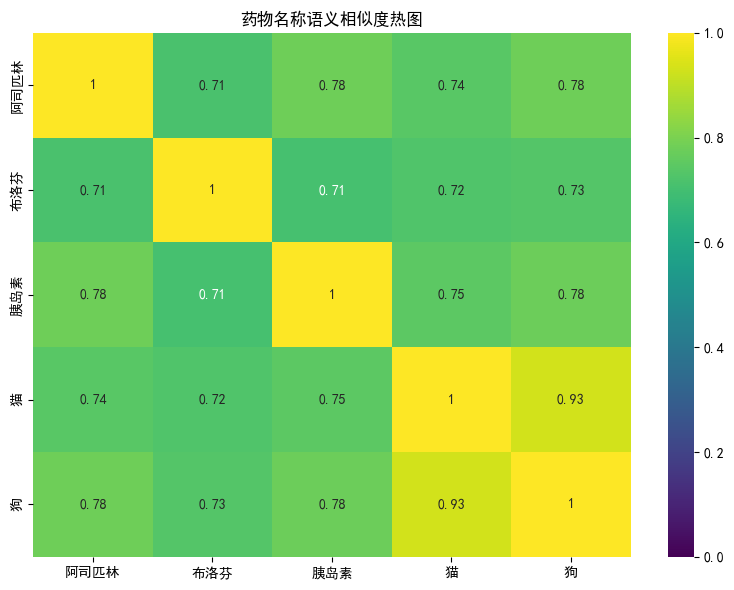

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载 BERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained(r'E:\models\bert-chinese')  # 以 GLM 中文模型为例
model = AutoModel.from_pretrained(r'E:\models\bert-chinese')

# 药物名称列表
drug_names = ["阿司匹林", "布洛芬", "胰岛素", "猫",'狗']

# 计算药物名称的嵌入表示
def get_bert_embedding(text):
    # 分词并转换为模型输入
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # 获取模型输出
    outputs = model(**inputs)
    
    # 提取所有 token 的嵌入表示
    token_embeddings = outputs.last_hidden_state  # 形状: (batch_size, sequence_length, hidden_size)
    
    # 均值池化：对所有 token 的嵌入取平均值
    mean_embedding = torch.mean(token_embeddings, dim=1)  # 形状: (batch_size, hidden_size)
    
    # 转换为 NumPy 数组并返回
    return mean_embedding.detach().numpy()

drug_embeddings = np.array([get_glm_embedding(name) for name in drug_names])
drug_embeddings = drug_embeddings.reshape(len(drug_names), -1)  # 调整形状

# 计算语义相似度矩阵
similarity_matrix = np.dot(drug_embeddings, drug_embeddings.T)
norms = np.linalg.norm(drug_embeddings, axis=1)
similarity_matrix = similarity_matrix / np.outer(norms, norms)  # 归一化

print(similarity_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=drug_names, columns=drug_names)

# 创建热图
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='viridis', vmin=0, vmax=1)

# 添加标题
plt.title("药物名称语义相似度热图")

# 显示热图
plt.tight_layout()
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_33208\2417452870.py:55: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_33208\2417452870.py:55: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_33208\2417452870.py:64: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.savefig('Soft_Hits_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\David\AppData\Local\Temp\ipykernel_33208\2417452870.py:64: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.savefig('Soft_Hits_comparison.png', dpi=300, bbox_inches='tight')
d:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\l

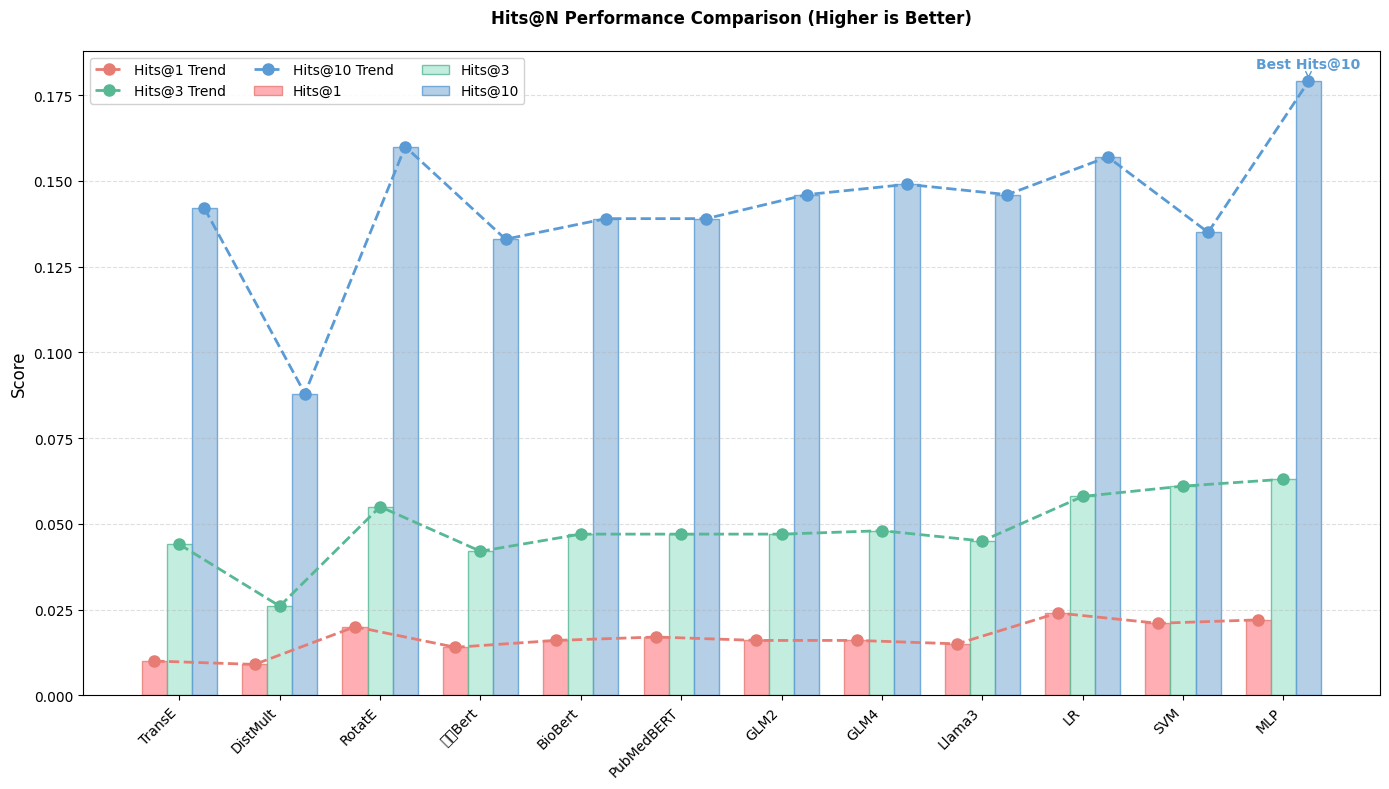

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
# 数据准备
methods = ['TransE', 'DistMult', 'RotatE', '原始Bert', 'BioBert', 'PubMedBERT', 
           'GLM2', 'GLM4', 'Llama3', 'LR', 'SVM', 'MLP']
Hits1 = [0.010, 0.009, 0.020, 0.014, 0.016, 0.017, 0.016, 0.016, 0.015, 0.024, 0.021, 0.022]
Hits3 = [0.044, 0.026, 0.055, 0.042, 0.047, 0.047, 0.047, 0.048, 0.045, 0.058, 0.061, 0.063]
Hits10 = [0.142, 0.088, 0.160, 0.133, 0.139, 0.139, 0.146, 0.149, 0.146, 0.157, 0.135, 0.179]

# 柔和的颜色设置 (pastel色调)
hits_colors = {
    'Hits@1': '#FF9AA2',  # 柔和的粉红色
    'Hits@3': '#B5EAD7',  # 柔和的薄荷绿
    'Hits@10': '#A2C4E0'  # 柔和的浅蓝色
}
line_colors = {
    'Hits@1': '#E67C73',  # 稍深的粉红
    'Hits@3': '#57B894',  # 稍深的绿色
    'Hits@10': '#5A9BD5'  # 稍深的蓝色
}

# 创建画布
plt.figure(figsize=(14, 8))
bar_width = 0.25
x = np.arange(len(methods))

# 绘制柱状图（使用柔和颜色）
bars1 = plt.bar(x - bar_width, Hits1, width=bar_width, 
                label='Hits@1', color=hits_colors['Hits@1'], 
                edgecolor=line_colors['Hits@1'], alpha=0.8)
bars2 = plt.bar(x, Hits3, width=bar_width, 
                label='Hits@3', color=hits_colors['Hits@3'], 
                edgecolor=line_colors['Hits@3'], alpha=0.8)
bars3 = plt.bar(x + bar_width, Hits10, width=bar_width, 
                label='Hits@10', color=hits_colors['Hits@10'], 
                edgecolor=line_colors['Hits@10'], alpha=0.8)

# 添加折线（使用稍深的同色系）
plt.plot(x - bar_width, Hits1, '--', color=line_colors['Hits@1'], 
         marker='o', markersize=8, label='Hits@1 Trend', linewidth=2)
plt.plot(x, Hits3, '--', color=line_colors['Hits@3'], 
         marker='o', markersize=8, label='Hits@3 Trend', linewidth=2)
plt.plot(x + bar_width, Hits10, '--', color=line_colors['Hits@10'], 
         marker='o', markersize=8, label='Hits@10 Trend', linewidth=2)

# 图表装饰
plt.title('不同模型在DDI数据集上的Hits指标对比（含折线）', fontweight='bold', pad=20)
plt.ylabel('指标得分', fontsize=12)
plt.xticks(x, methods, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 优化图例和布局
plt.legend(ncol=3, loc='upper left', framealpha=0.9)
plt.tight_layout()

# 高亮最优值
best_hits10 = np.argmax(Hits10)
plt.annotate(' Hits@10', xy=(best_hits10 + bar_width, Hits10[best_hits10]), 
             xytext=(0, 10), textcoords='offset points', ha='center',
             fontweight='bold', color=line_colors['Hits@10'],
             arrowprops=dict(arrowstyle='->', color=line_colors['Hits@10']))

plt.savefig('Soft_Hits_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

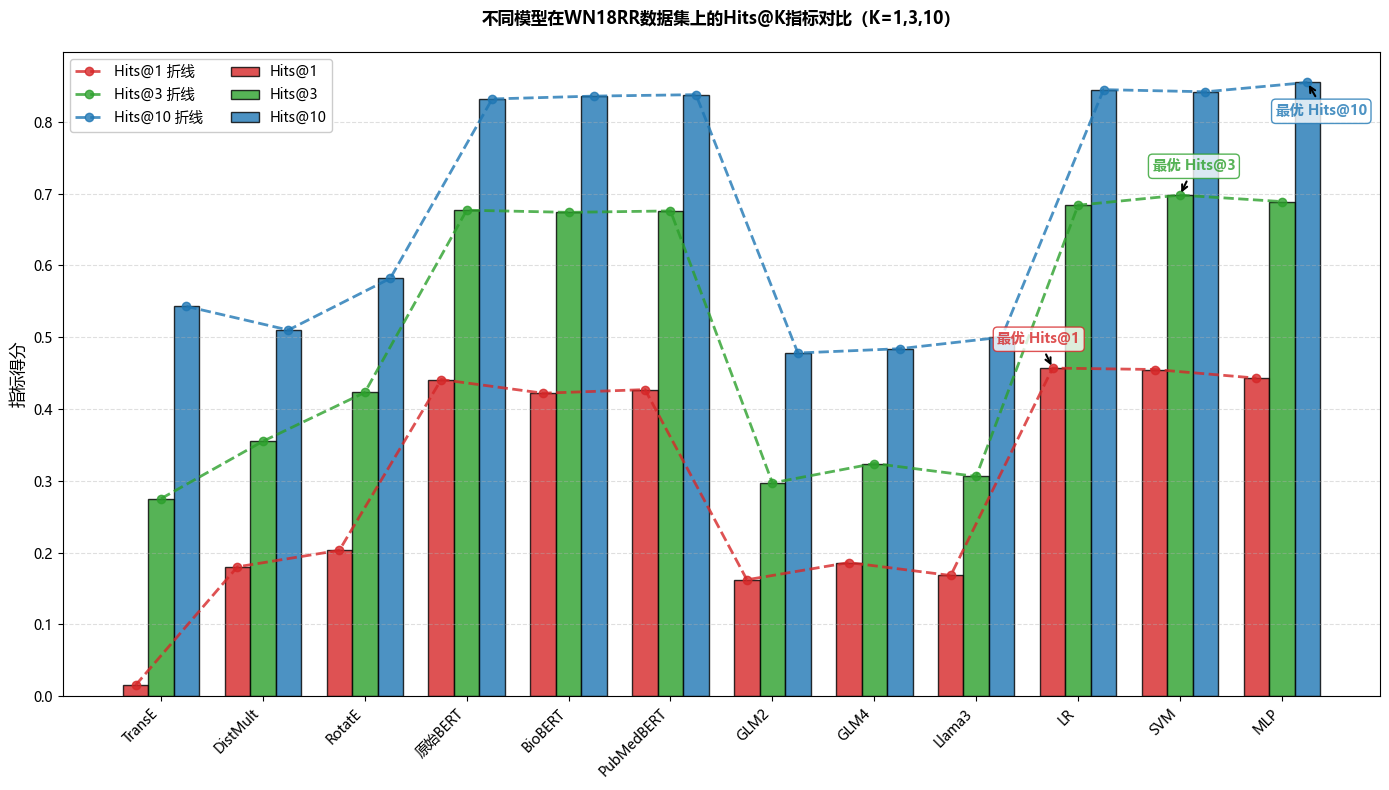

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
# 数据准备
methods = ['TransE', 'DistMult', 'RotatE', '原始BERT', 'BioBERT', 'PubMedBERT', 
           'GLM2', 'GLM4', 'Llama3', 'LR', 'SVM', 'MLP']
#Hits1 = [0.010, 0.009, 0.020, 0.014, 0.016, 0.017, 0.016, 0.016, 0.015, 0.024, 0.026, 0.025]
#Hits3 = [0.044, 0.026, 0.055, 0.042, 0.047, 0.047, 0.047, 0.048, 0.045, 0.058, 0.064, 0.068]
#Hits10 = [0.142, 0.088, 0.160, 0.133, 0.139, 0.139, 0.146, 0.149, 0.146, 0.157, 0.155, 0.189]

#Hits1 = [0.001, 0.015, 0.001, 0.178, 0.173, 0.139, 0.111, 0.173, 0.095, 0.225, 0.237, 0.210]
#Hits3 = [0.060, 0.099, 0.074, 0.415, 0.415, 0.374, 0.244, 0.301, 0.208, 0.526, 0.510, 0.525]
#Hits10 = [0.691, 0.454, 0.752, 0.662, 0.643, 0.648, 0.584, 0.613, 0.558, 0.751, 0.711, 0.794]


Hits1 = [0.015, 0.180, 0.203, 0.441, 0.422, 0.427, 0.162, 0.186, 0.168, 0.457, 0.455, 0.443]
Hits3 = [0.275, 0.355, 0.423, 0.677, 0.674, 0.676, 0.297, 0.324, 0.306, 0.684, 0.698, 0.689]
Hits10 = [0.543, 0.510, 0.582, 0.832, 0.836, 0.838, 0.478, 0.484, 0.500, 0.845, 0.842, 0.855]
# 颜色和线型设置
#colors = {'Hits@1': '#d62728', 'Hits@3': '#2ca02c', 'Hits@10': '#1f77b4'}
linestyles = {'Hits@1': 'dashed', 'Hits@3': 'dashed', 'Hits@10': 'dashed'}
colors = {
    'Hits@1': (214/255, 39/255, 40/255, 0.8),   # 柔和红色，原'#d62728'
    'Hits@3': (44/255, 160/255, 44/255, 0.8),   # 柔和绿色，原'#2ca02c'
    'Hits@10': (31/255, 119/255, 180/255, 0.8)  # 柔和蓝色，原'#1f77b4'
}




# 创建画布
plt.figure(figsize=(14, 8))
bar_width = 0.25
#x = np.arange(len(methods))
x = np.arange(len(methods))


# 绘制柱状图
bars1 = plt.bar(x - bar_width, Hits1, width=bar_width, 
                label='Hits@1', color=colors['Hits@1'], 
                edgecolor='k', alpha=0.8)
bars2 = plt.bar(x, Hits3, width=bar_width, 
                label='Hits@3', color=colors['Hits@3'], 
                edgecolor='k', alpha=0.8)
bars3 = plt.bar(x + bar_width, Hits10, width=bar_width, 
                label='Hits@10', color=colors['Hits@10'], 
                edgecolor='k', alpha=0.8)
#plt.xlim(-1.5, len(methods)+0.2)  # 左边留出0.2空白，右边保持对称
# 添加折线
plt.plot(x - bar_width, Hits1, linestyle=linestyles['Hits@1'], 
         color=colors['Hits@1'], marker='o', markersize=6, 
         label='Hits@1 折线', linewidth=2)
plt.plot(x, Hits3, linestyle=linestyles['Hits@3'], 
         color=colors['Hits@3'], marker='o', markersize=6,
         label='Hits@3 折线', linewidth=2)
plt.plot(x + bar_width, Hits10, linestyle=linestyles['Hits@10'], 
         color=colors['Hits@10'], marker='o', markersize=6, 
         label='Hits@10 折线', linewidth=2)

# 图表装饰
plt.title('不同模型在WN18RR数据集上的Hits@K指标对比（K=1,3,10）', fontweight='bold', pad=20)
plt.ylabel('指标得分', fontsize=12)
plt.xticks(x, methods, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 优化图例
plt.legend(ncol=2, loc='upper left', framealpha=1)
#plt.subplots_adjust(top=10)
plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 1.3])  # top=0.9表示保留10%顶部空间

# 标注所有最佳值
def annotate_best(ax, values, offset, color, label, is_hits10=False):
    best_idx = np.argmax(values)
    x = best_idx + (offset * bar_width)
    y = values[best_idx]
    
    # 设置偏移：往上偏移+更多一些，并稍微往右偏移
    xytext_offset = (10, 15) if offset >= 0 else (-10, 15)
    
    # 如果是Hits@10，箭头从下方指向
    if is_hits10:
        xytext_offset = (10, -15)  # 使文本向下偏移
        arrowprops = dict(arrowstyle='->', color='black', lw=1.5, connectionstyle="angle,angleA=0,angleB=-60,rad=10")
    else:
        arrowprops = dict(arrowstyle='->', color='black', lw=1.5)

    ax.annotate(f'最优 {label}',
                xy=(x, y),
                xytext=xytext_offset, textcoords='offset points',
                ha='center', va='bottom' if not is_hits10 else 'top', fontweight='bold', color=color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.8),
                arrowprops=arrowprops)


# 示例调用
annotate_best(plt.gca(), Hits1, -1, colors['Hits@1'], 'Hits@1')  # Hits@1最佳 (LR)
annotate_best(plt.gca(), Hits3, 0, colors['Hits@3'], 'Hits@3')    # Hits@3最佳 (MLP)
annotate_best(plt.gca(), Hits10, 1, colors['Hits@10'], 'Hits@10', is_hits10=True)  # Hits@10最佳 (MLP)

plt.savefig('LR_WN18RR_Hits_comparison_with_best_annotations.png', dpi=300, bbox_inches='tight')
plt.show()


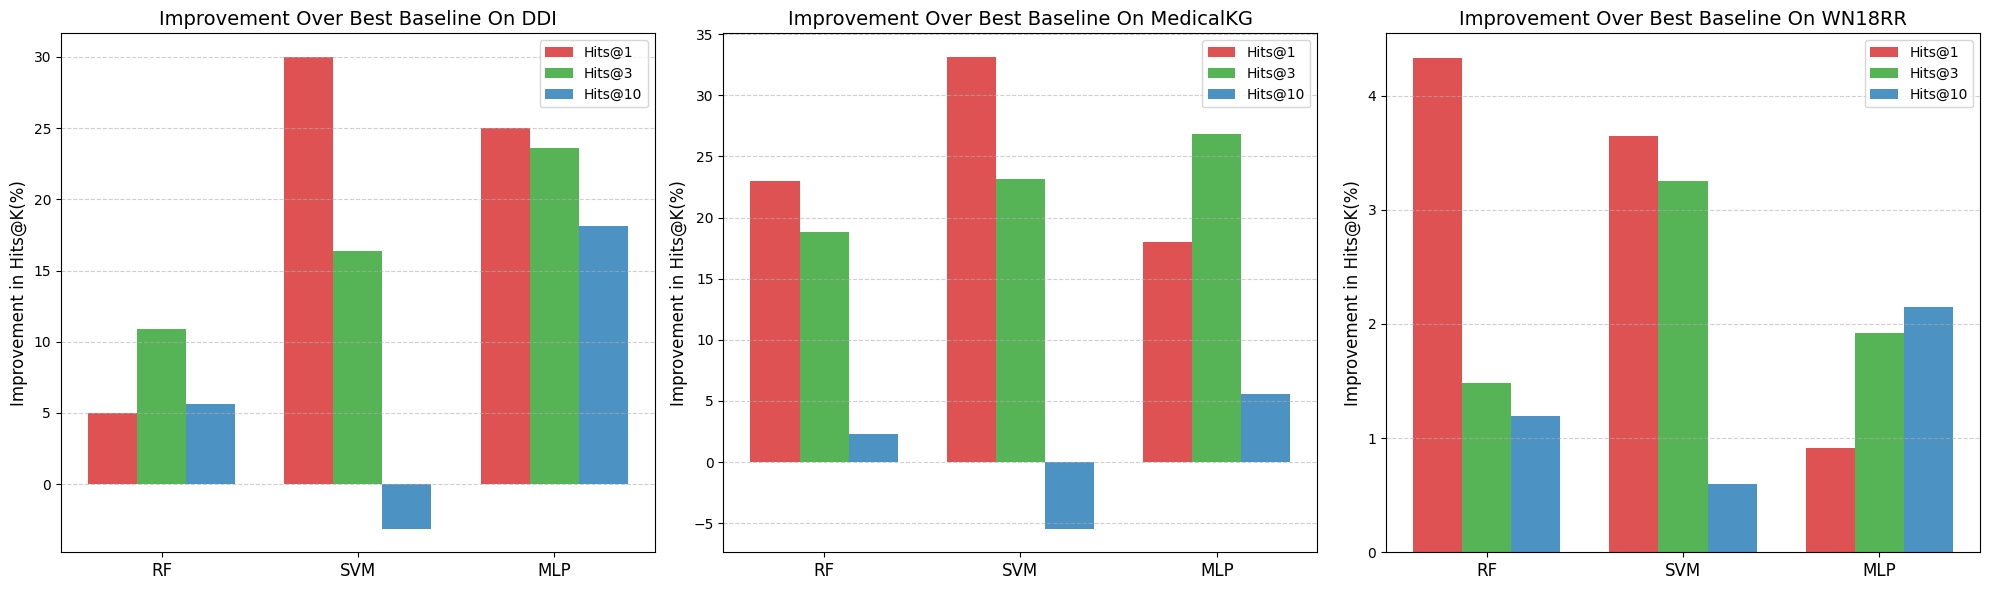

In [1]:
#三合一
import numpy as np
import matplotlib.pyplot as plt

# 模型列表
methods = ['TransE', 'DistMult', 'RotatE', '原始BERT', 'BioBERT', 'PubMedBERT',
           'GLM2', 'GLM4', 'Llama3', 'RF', 'SVM', 'MLP']
fusion_models = ['RF', 'SVM', 'MLP']
fusion_indices = [methods.index(m) for m in fusion_models]

# 三个数据集的指标值
datasets = {
    'DDI': {
        'Hits1' : np.array([0.010, 0.009, 0.020, 0.014, 0.016, 0.016, 0.018, 0.019, 0.015, 0.021, 0.026, 0.025]),
        'Hits3' : np.array([0.044, 0.026, 0.055, 0.042, 0.046, 0.047, 0.050, 0.055, 0.045, 0.061, 0.064, 0.068]),
        'Hits10' : np.array([0.142, 0.088, 0.160, 0.132, 0.138, 0.138, 0.148, 0.158, 0.146, 0.169, 0.155, 0.189]) 
    },
    'MedicalKG': {
        "Hits1" : np.array([0.001, 0.015, 0.001, 0.178, 0.169, 0.138, 0.111, 0.173, 0.095, 0.219, 0.237, 0.210]),
        "Hits3" : np.array([0.060, 0.099, 0.074, 0.410, 0.414, 0.372, 0.244, 0.301, 0.208, 0.492, 0.510, 0.525]),
        "Hits10" : np.array([0.691, 0.454, 0.752, 0.659, 0.640, 0.647, 0.584, 0.613, 0.558, 0.769, 0.711, 0.794])
    },
    'WN18RR': {
        "Hits1" : np.array([0.015, 0.180, 0.203, 0.439, 0.420, 0.426, 0.196, 0.255, 0.198, 0.458, 0.455, 0.443]),
        "Hits3" : np.array([0.275, 0.355, 0.423, 0.676, 0.673, 0.675, 0.304, 0.337, 0.306, 0.686, 0.698, 0.689]),
        "Hits10" : np.array([0.543, 0.510, 0.582, 0.831, 0.834, 0.837, 0.478, 0.484, 0.500, 0.847, 0.842, 0.855])
    }
}


# 绘图
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

colors = [(214/255, 39/255, 40/255, 0.8),
          (44/255, 160/255, 44/255, 0.8),
          (31/255, 119/255, 180/255, 0.8)]

for ax, (dataset_name, values) in zip(axes, datasets.items()):
    Hits1 = values['Hits1']
    Hits3 = values['Hits3']
    Hits10 = values['Hits10']
    
    fusion_Hits1 = Hits1[fusion_indices]
    fusion_Hits3 = Hits3[fusion_indices]
    fusion_Hits10 = Hits10[fusion_indices]

    baseline_max_Hits1 = np.max(Hits1[:9])
    baseline_max_Hits3 = np.max(Hits3[:9])
    baseline_max_Hits10 = np.max(Hits10[:9])

    improve_Hits1 = (fusion_Hits1 - baseline_max_Hits1) / baseline_max_Hits1 * 100
    improve_Hits3 = (fusion_Hits3 - baseline_max_Hits3) / baseline_max_Hits3 * 100
    improve_Hits10 = (fusion_Hits10 - baseline_max_Hits10) / baseline_max_Hits10 * 100

    x = np.arange(len(fusion_models))
    width = 0.25

    ax.bar(x - width, improve_Hits1, width, label='Hits@1', color=colors[0])
    ax.bar(x, improve_Hits3, width, label='Hits@3', color=colors[1])
    ax.bar(x + width, improve_Hits10, width, label='Hits@10', color=colors[2])

    ax.set_xticks(x)
    ax.set_xticklabels(fusion_models, fontsize=12)
    ax.set_ylabel('Improvement in Hits@K(%)', fontsize=12)
    ax.set_title(f'Improvement Over Best Baseline On {dataset_name}', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout()
plt.show()




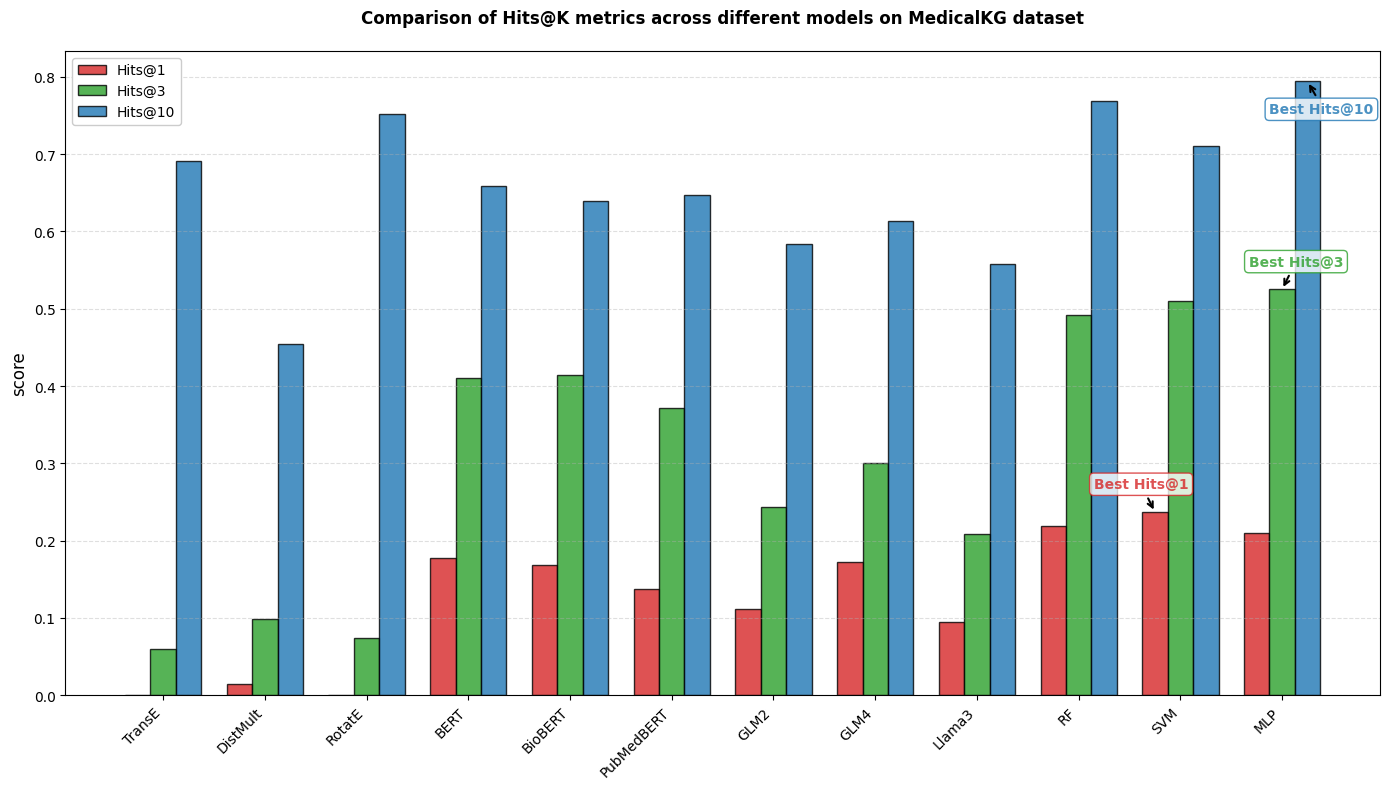

In [4]:
#RF结果

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 黑体
#plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
# 数据准备
methods = ['TransE', 'DistMult', 'RotatE', 'BERT', 'BioBERT', 'PubMedBERT', 
           'GLM2', 'GLM4', 'Llama3', 'RF', 'SVM', 'MLP']
#Hits1 = np.array([0.010, 0.009, 0.020, 0.014, 0.016, 0.016, 0.018, 0.019, 0.015, 0.021, 0.026, 0.025])
#Hits3 = np.array([0.044, 0.026, 0.055, 0.042, 0.046, 0.047, 0.050, 0.055, 0.045, 0.061, 0.064, 0.068])
#Hits10 = np.array([0.142, 0.088, 0.160, 0.132, 0.138, 0.138, 0.148, 0.158, 0.146, 0.169, 0.155, 0.189])

Hits1 = np.array([0.001, 0.015, 0.001, 0.178, 0.169, 0.138, 0.111, 0.173, 0.095, 0.219, 0.237, 0.210])
Hits3 = np.array([0.060, 0.099, 0.074, 0.410, 0.414, 0.372, 0.244, 0.301, 0.208, 0.492, 0.510, 0.525])
Hits10 = np.array([0.691, 0.454, 0.752, 0.659, 0.640, 0.647, 0.584, 0.613, 0.558, 0.769, 0.711, 0.794])


#Hits1 = np.array([0.015, 0.180, 0.203, 0.439, 0.420, 0.426, 0.196, 0.255, 0.198, 0.458, 0.455, 0.443])
#Hits3 = np.array([0.275, 0.355, 0.423, 0.676, 0.673, 0.675, 0.304, 0.337, 0.306, 0.686, 0.698, 0.689])
#Hits10 = np.array([0.543, 0.510, 0.582, 0.831, 0.834, 0.837, 0.478, 0.484, 0.500, 0.847, 0.842, 0.855])
# 颜色和线型设置
#colors = {'Hits@1': '#d62728', 'Hits@3': '#2ca02c', 'Hits@10': '#1f77b4'}
linestyles = {'Hits@1': 'dashed', 'Hits@3': 'dashed', 'Hits@10': 'dashed'}
colors = {
    'Hits@1': (214/255, 39/255, 40/255, 0.8),   # 柔和红色，原'#d62728'
    'Hits@3': (44/255, 160/255, 44/255, 0.8),   # 柔和绿色，原'#2ca02c'
    'Hits@10': (31/255, 119/255, 180/255, 0.8)  # 柔和蓝色，原'#1f77b4'
}




# 创建画布
plt.figure(figsize=(14, 8))
bar_width = 0.25
#x = np.arange(len(methods))
x = np.arange(len(methods))


# 绘制柱状图
bars1 = plt.bar(x - bar_width, Hits1, width=bar_width, 
                label='Hits@1', color=colors['Hits@1'], 
                edgecolor='k', alpha=0.8)
bars2 = plt.bar(x, Hits3, width=bar_width, 
                label='Hits@3', color=colors['Hits@3'], 
                edgecolor='k', alpha=0.8)
bars3 = plt.bar(x + bar_width, Hits10, width=bar_width, 
                label='Hits@10', color=colors['Hits@10'], 
                edgecolor='k', alpha=0.8)
#plt.xlim(-1.5, len(methods)+0.2)  # 左边留出0.2空白，右边保持对称
# 添加折线
#plt.plot(x - bar_width, Hits1, linestyle=linestyles['Hits@1'], 
#         color=colors['Hits@1'], marker='o', markersize=6, 
#         label='Hits@1 trend', linewidth=2)
#plt.plot(x, Hits3, linestyle=linestyles['Hits@3'], 
#         color=colors['Hits@3'], marker='o', markersize=6,
#         label='Hits@3 trend', linewidth=2)
#plt.plot(x + bar_width, Hits10, linestyle=linestyles['Hits@10'], 
#         color=colors['Hits@10'], marker='o', markersize=6, 
#         label='Hits@10 trend', linewidth=2)

# 图表装饰
plt.title('Comparison of Hits@K metrics across different models on MedicalKG dataset', fontweight='bold', pad=20)
plt.ylabel('score', fontsize=12)
plt.xticks(x, methods, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 优化图例
plt.legend(ncol=1, loc='upper left', framealpha=1)
#plt.subplots_adjust(top=10)
plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 1.3])  # top=0.9表示保留10%顶部空间

# 标注所有最佳值
def annotate_best(ax, values, offset, color, label, is_hits10=False):
    best_idx = np.argmax(values)
    x = best_idx + (offset * bar_width)
    y = values[best_idx]
    
    # 设置偏移：往上偏移+更多一些，并稍微往右偏移
    xytext_offset = (10, 15) if offset >= 0 else (-10, 15)
    
    # 如果是Hits@10，箭头从下方指向
    if is_hits10:
        xytext_offset = (10, -15)  # 使文本向下偏移
        arrowprops = dict(arrowstyle='->', color='black', lw=1.5, connectionstyle="angle,angleA=0,angleB=-60,rad=10")
    else:
        arrowprops = dict(arrowstyle='->', color='black', lw=1.5)

    ax.annotate(f'Best {label}',
                xy=(x, y),
                xytext=xytext_offset, textcoords='offset points',
                ha='center', va='bottom' if not is_hits10 else 'top', fontweight='bold', color=color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.8),
                arrowprops=arrowprops)


# 示例调用
annotate_best(plt.gca(), Hits1, -1, colors['Hits@1'], 'Hits@1')  # Hits@1最佳 (LR)
annotate_best(plt.gca(), Hits3, 0, colors['Hits@3'], 'Hits@3')    # Hits@3最佳 (MLP)
annotate_best(plt.gca(), Hits10, 1, colors['Hits@10'], 'Hits@10', is_hits10=True)  # Hits@10最佳 (MLP)

plt.savefig('MedicalKG_Hits_comparison_with_best_annotations_RF.png', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
from sklearn.metrics import roc_auc_score

# 真实标签
y_true = [0, 0,0,0,1, 1, 1]

# 预测概率
y_scores = [0.1,0.7,0.3,0.4,0.6,0.8,0.9]

# 计算 AUC
auc = roc_auc_score(y_true, y_scores)

print(f"AUC = {auc:.4f}")


AUC = 0.9167


In [3]:
n = int(input())
house = []
for _ in range(2):
    row = list(map(int, input().split()))
    house.append(row)
dp = [[0]*n for _ in range(2)]
#for i in range(n):
    #dp[0][i] = abs(house[0][i]-house[1][i])
    #dp[1][i] = abs(house[0][i]-house[1][i])
if n == 1:
    print(0)
for i in range(1, n):
    #dp[0][i] = min(dp[0][i-1]+abs(house[0][i] - house[0][i-1]), dp[1][i-1]+3 * abs(house[0][i] - house[1][i-1]), dp[1][i]+2 * abs(house[0][i] - house[1][i]))
    #dp[1][i] = min(dp[1][i-1]+abs(house[1][i] - house[1][i-1]), dp[0][i-1]+3 * abs(house[1][i] - house[0][i-1]), dp[0][i]+2 * abs(house[1][i] - house[0][i]))
    dp[0][i] = min(dp[0][i-1]+abs(house[0][i] - house[0][i-1]), dp[1][i-1]+3 * abs(house[0][i] - house[1][i-1]))
    dp[1][i] = min(dp[1][i-1]+abs(house[1][i] - house[1][i-1]), dp[0][i-1]+3 * abs(house[1][i] - house[0][i-1]))
#for i in range(1, n):
    dp[0][i] = min(dp[0][i], dp[1][i]+2 * abs(house[0][i] - house[1][i]))
    dp[1][i] = min(dp[1][i], dp[0][i]+2 * abs(house[1][i] - house[0][i]))



print(min(dp[0][n-1], dp[1][n-1]))


31


In [1]:
n = int(input())
house = []
for _ in range(2):
    row = list(map(int, input().split()))
    house.append(row)

if n == 1:
    print(0)
    exit()

# 初始化DP表
dp = [[float('inf')] * n for _ in range(2)]
dp[0][0] = 0  # 从第一排出发的初始时间
dp[1][0] = 0  # 从第二排出发的初始时间

for i in range(1, n):
    # 更新第一排i的最小时间
    cost_same_row = dp[0][i-1] + abs(house[0][i] - house[0][i-1])
    cost_cross_prev = dp[1][i-1] + 3 * abs(house[0][i] - house[1][i-1])
    dp[0][i] = min(cost_same_row, cost_cross_prev)

    # 更新第二排i的最小时间
    cost_same_row = dp[1][i-1] + abs(house[1][i] - house[1][i-1])
    cost_cross_prev = dp[0][i-1] + 3 * abs(house[1][i] - house[0][i-1])
    dp[1][i] = min(cost_same_row, cost_cross_prev)

    # 处理同列跨排（从第一排i到第二排i，或反之）
    cost_cross_same = 2 * abs(house[0][i] - house[1][i])
    dp[0][i] = min(dp[0][i], dp[1][i] + cost_cross_same)
    dp[1][i] = min(dp[1][i], dp[0][i] + cost_cross_same)

print(min(dp[0][n-1], dp[1][n-1]))

31


In [7]:
def fn(a=[],b=1):
     a.append(1)
fn()
print(fn.__defaults__)

([1], 1)


In [10]:
s = "Happy 牛 Year"
s[-5:]

' Year'